# Path Integral Methods

## Density Matrices

### Quantum Harmonic Oscillator

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.core.pylabtools import figsize

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)


def harmonic_wavefunction(n,x):
    if n==-1:
        return 0
    if n==0:
        return np.pi**(-1.0/4) * np.exp(-x**2/2.0)
    return np.sqrt(2.0/n)*x*harmonic_wavefunction(n-1,x)-np.sqrt((n-1.0)/n)*harmonic_wavefunction(n-2,x)

harmonic_wavefunction_vectorise = np.vectorize(harmonic_wavefunction)

/Users/borundev/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


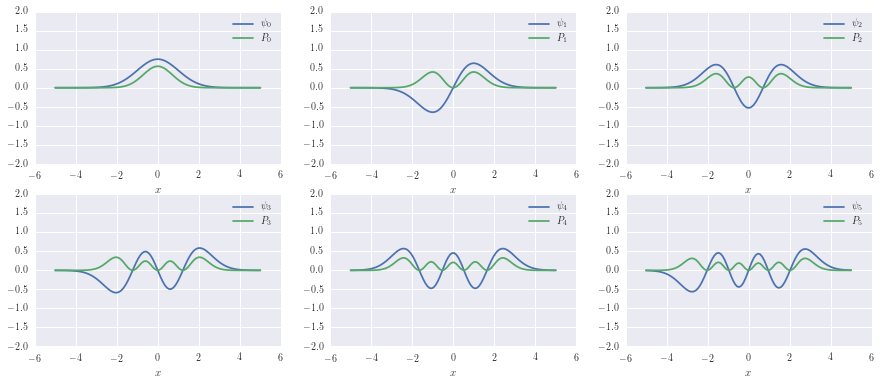

In [2]:
number_columns=3
number_rows=2
figsize(15, 6)
xs=np.linspace(-5,5,100)

for i,j in enumerate([(i/number_columns,i%number_columns) for i in range(number_columns*number_rows)]):
    plt.subplot2grid((number_rows,number_columns),j)
    plt.plot(xs,harmonic_wavefunction_vectorise(i,xs),"-",label=r"$\psi_"+str(i)+"$")
    plt.plot(xs,harmonic_wavefunction_vectorise(i,xs)**2,"-",label=r"$P_"+str(i)+"$")
    plt.xlabel(r"$x$")
    plt.ylim(-2,2)
    plt.legend()

plt.show()

Check normalization of probability

In [3]:
[np.sum(harmonic_wavefunction(i,xs)**2*(xs[5]-xs[4])) for i in range(6)]

[0.99999999999912503,
 0.99999999995337963,
 0.9999999988055871,
 0.99999998037401061,
 0.99999976782077959,
 0.99999789581845122]

The probability of being at a location $x$ for an energy eigenstate given by $n$ is just $|\psi_n(x)|^2$. In the canonical ensemble we need to sum this with the Boltzman factor

In [4]:
def harmonic_density(beta,x,xp,nmax=10):
    rho=0.0
    for i in range(nmax):
        rho=rho+np.exp(-beta*i)*harmonic_wavefunction(i,x)*harmonic_wavefunction(i,xp)
    return rho

def probability(beta,x,nmax=10):
    rho=harmonic_density(beta,x,x,nmax)
    Z=np.sum(rho*(x[1]-x[0]))
    return rho/Z
    

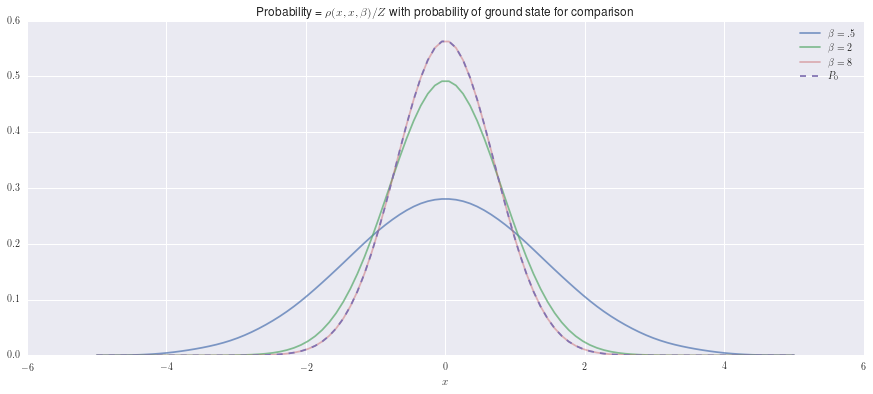

In [5]:
plt.plot(xs,probability(.5,xs),label=r"$\beta=.5$",alpha=.7)
plt.plot(xs,probability(2,xs),label=r"$\beta=2$",alpha=.7)
plt.plot(xs,probability(8,xs),label=r"$\beta=8$",alpha=.4)
plt.plot(xs,harmonic_wavefunction_vectorise(0,xs)**2,"--",label=r"$P_"+str(0)+"$")
plt.xlabel(r"$x$")
plt.title(r"Probability = $\rho(x,x,\beta)/Z$ with probability of ground state for comparison")
plt.legend()

The **exact expression for the harmonic oscillator density function** is given by

$$
\rho(x,x',\beta)= \sqrt{\frac{1}{2 \pi \sinh \beta}} exp\left(-\frac{(x+x')^2}{4} \tanh \frac{\beta}{2}-\frac{(x-x')^2}{4} \coth \frac{\beta}{2}\right)
$$

and the partition function is

$$
Z= \int dx ~\rho(x,x,\beta)= \frac{1}{2 \sinh(\beta/2)}
$$

We plot them again to see they match the results we got from explicit summing

In [6]:
def harmonic_density_exact(beta,x,xp):
    return np.sqrt(1/(2*np.pi*np.sinh(beta)))*np.exp(-(x+xp)**2/4.0*np.tanh(beta/2.0) - (x-xp)**2/4.0/np.tanh(beta/2.0))


def probability_exact(beta,x):
    rho=harmonic_density_exact(beta,x,x)
    return 2*np.sinh(beta/2.0)*rho

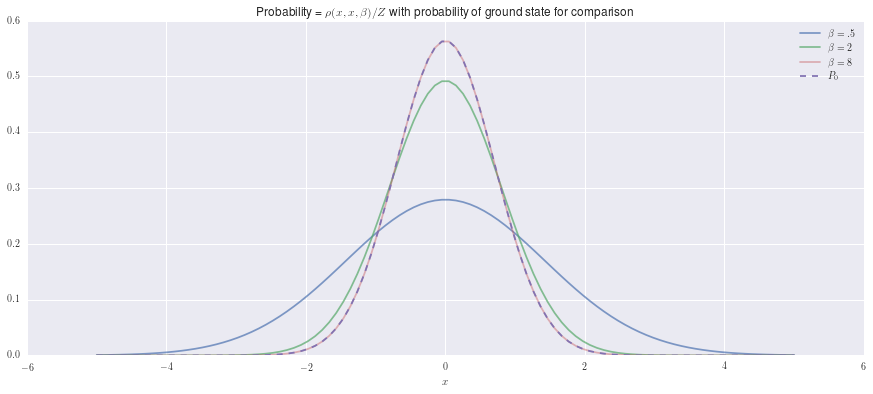

In [7]:
plt.plot(xs,probability_exact(.5,xs),label=r"$\beta=.5$",alpha=.7)
plt.plot(xs,probability_exact(2,xs),label=r"$\beta=2$",alpha=.7)
plt.plot(xs,probability_exact(8,xs),label=r"$\beta=8$",alpha=.4)
plt.plot(xs,harmonic_wavefunction_vectorise(0,xs)**2,"--",label=r"$P_"+str(0)+"$")
plt.xlabel(r"$x$")
plt.title(r"Probability = $\rho(x,x,\beta)/Z$ with probability of ground state for comparison")
plt.legend()

Furthermore we check the convolution property 

$$
\rho(x,x,2 \beta) = \int dx' \rho(x,x',\beta) \rho(x',x,\beta)
$$

graphically

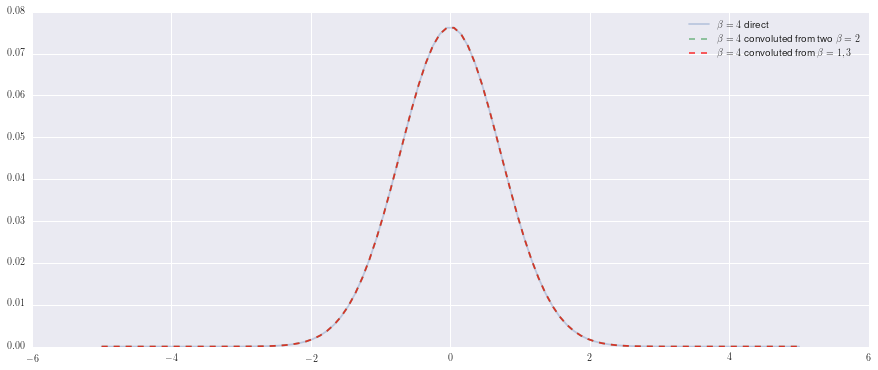

In [8]:
first=harmonic_density_exact(4,xs,xs)
second=np.array([np.sum([harmonic_density_exact(2,x1,x2)*harmonic_density_exact(2,x2,x1) for x2 in xs])*(xs[1]-xs[0]) for x1 in xs])
third=np.array([np.sum([harmonic_density_exact(1,x1,x2)*harmonic_density_exact(3,x2,x1) for x2 in xs])*(xs[1]-xs[0]) for x1 in xs])


plt.plot(xs,first,"-",label=r"$\beta=4$ direct",alpha=.3)
plt.plot(xs,second,"--",label=r"$\beta=4$ convoluted from two $\beta=2$",alpha=.7)
plt.plot(xs,third,"r--",label=r"$\beta=4$ convoluted from $\beta=1,3$",alpha=.7)


plt.legend()



## Feynman Path Integral

The density matrices enjoy a convolution property

$$
\rho(x,x',\beta)=\int dx''~\rho(x,x'',\beta_1) \rho(x'',x',\beta-\beta_1)
$$

and this hints at using the integrand as a probability density for a Monte Carlo method of doing the integration. We will first do this by a naive method where we sample $x''$ by using a uniform distribution. We will need the denisity function for the free particle

$$
\rho_{\text{free}}(x,x',\beta)= \sqrt{\frac{1}{2 \pi \beta}} exp\left(- \frac{(x-x')^2}{2 \beta} \right)
$$


In [9]:
def rho_free(x,xp,beta):
    return np.sqrt(1/(2*np.pi*beta))*np.exp(-(x-xp)**2/(2*beta))

We will also need the Trotter formula that approximates the high temperature density matrix

$$
\rho(x,x',\beta) \approx e^{-\frac{1}{2} \beta V(x)}\rho_{\text{free}}(x,x',\beta) e^{-\frac{1}{2} \beta V(x')}
$$

We can now demonstrate the Naive sampling to get the probability density for a harmonic oscillator

### Naive sampling

Here we choose arbitray points in the sequence of steps

In [10]:
def naive_harmonic_path(xs,beta,step_size):
    reject=True
    n=xs.shape[0]
    delta=1.0*beta/n
    k=np.random.choice(range(n))
    kp=np.mod(k+1,n)
    km=np.mod(k-1,n)
    shift=np.random.uniform(-step_size,step_size)
    xkp=xs[k]+shift
    prob_current=rho_free(xs[km],xs[k],delta)*rho_free(xs[k],xs[kp],delta)*np.exp(-.5*delta*xs[k]**2)
    prob_if_changed=rho_free(xs[km],xkp,delta)*rho_free(xkp,xs[kp],delta)*np.exp(-.5*delta*xkp**2)
    gamma=prob_if_changed/prob_current
    if np.random.uniform() < gamma:
        xs[k]=xkp
        reject=False
    return (xs,reject)

    

In [11]:
xs=np.zeros(8)
x0=[]
reject=[]
delta=1.5
for i in range(10**6):
    xs,r=naive_harmonic_path(xs,4,delta)
    x0.append(xs[0])
    reject.append(r)
print delta,np.sum(reject)

1.5 527667


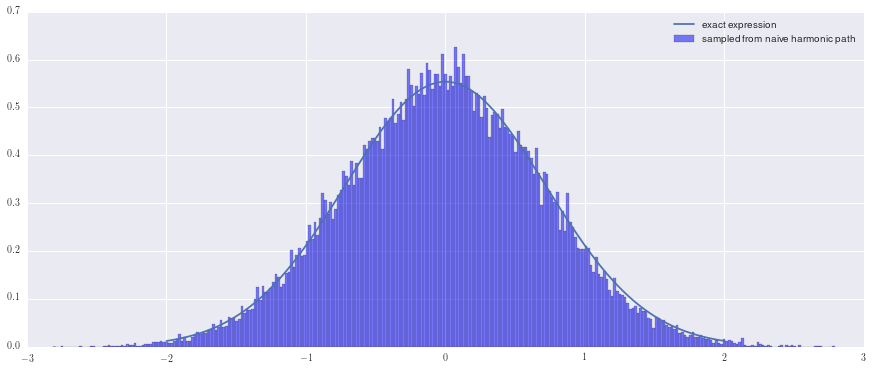

In [38]:
plt.hist(x0,bins=300,normed=True,alpha=.5,color="b",label="sampled from naive harmonic path ")
plt.plot(np.linspace(-2,2,100),probability_exact(4,np.linspace(-2,2,100)),label="exact expression")
plt.legend()
plt.show()


### Direct sampling

Now given that we want to perform intermediate steps

$$
\int dy ~\rho(x_1,y,\beta_1) \rho(y,x_2,\beta-\beta_1) e^{- \beta V(y)}
$$

if we can sample from $\rho(x_1,y,\beta_1) \rho(y,x_2,\beta-\beta_1)$ directly we would have fewer rejections than sampling from the uniform distribution. For **free density matrices** we get

$$
\begin{eqnarray}
\rho_{\text{free}}(x_1,y,\beta_1) \rho_{\text{free}}(y,x_2,\beta_2) &\propto& exp(-\frac{(y-x_1)^2}{2\beta_1})exp(-\frac{(y-x_2)^2}{2\beta_2}) \\
&\propto& exp(- \frac{(y- \langle y \rangle)^2}{2 \sigma^2})
\end{eqnarray}
$$

where

$$
\begin{eqnarray}
\langle y \rangle &=& \frac{\beta_2 x_1 + \beta_1 x_2}{\beta_1 + \beta_2} \\
\sigma^2 &=& (\beta_1^{-1} + \beta_2^{-1})^{-1}
\end{eqnarray}
$$


We can also do pretty much the same for the **harmonic oscillator density matrix** as that too is a gaussian. The parameters are ofcourse different.

$$
\begin{eqnarray}
\rho_{\text{free}}(x_1,y,\beta_1) \rho_{\text{free}}(y,x_2,\beta_2) &\propto& exp(- \frac{(y- \langle y \rangle)^2}{2 \sigma^2})
\end{eqnarray}
$$

where

$$
\begin{eqnarray}
\langle y \rangle &=& \frac{\gamma_2}{\gamma_1} \\
\sigma^2 &=& \gamma^{-1} \\
\gamma_1 &=& \coth \beta_1 + \coth \beta_2 \\
\gamma_2 &=& \frac{x_1}{\sinh \beta_1} + \frac{x_2}{\sinh \beta_2}
\end{eqnarray}
$$

Below we implement the latter.

In [16]:
# this function takes an array and performs the randomization keeping the first and last point fixed

def levy_harmonic_path(x0,xn,delta,n):
    x=np.zeros(n+1)
    x[0]=x0
    x[n]=xn
    for k in range(1,n):
        gamma1=1/np.tanh(delta) + 1/np.tanh((n-k)*delta)
        gamma2=x[k-1]/np.sinh(delta) +x[n]/np.sinh((n-k)*delta)
        mu=gamma2/gamma1
        sigma=1/np.sqrt(gamma1)
        x[k]=np.random.normal(mu,sigma)
    return x


def V(x,cubic,quartic):
    return  x ** 2 / 2.0 + cubic * x ** 3 + quartic * x ** 4


def V_anharm(x,cubic,quartic):
    return  cubic * x ** 3 + quartic * x ** 4

In [17]:
beta = 20.0
N = 100
dtau = beta / N
n_steps = 400000
x = np.zeros(N)+.1
data = []
Ncut = int(N/10.0)
g_cubic=-1.0
g_quartic=1.0

accepted=0

In [18]:
for step in range(n_steps):
    x_new=x.copy()
    x_new[:Ncut+1] = levy_harmonic_path(x[0], x[Ncut], dtau, Ncut)
    Trotter_weight_old = math.exp(np.sum(-V_anharm(x, g_cubic, g_quartic) * dtau))
    Trotter_weight_new = math.exp(np.sum(-V_anharm(x_new, g_cubic, g_quartic) * dtau))
    
    if np.random.uniform(0.0, 1.0) < Trotter_weight_new/Trotter_weight_old:
        x[:-1] = x_new[1:]
        x[-1]=x_new[0]
        accepted+=1
    
    if step % N == 0:
        k = np.random.randint(0, N - 1)
        data.append(x[k])
print 'acceptance rate='+str(1.0*accepted/n_steps)


acceptance rate=0.7467075


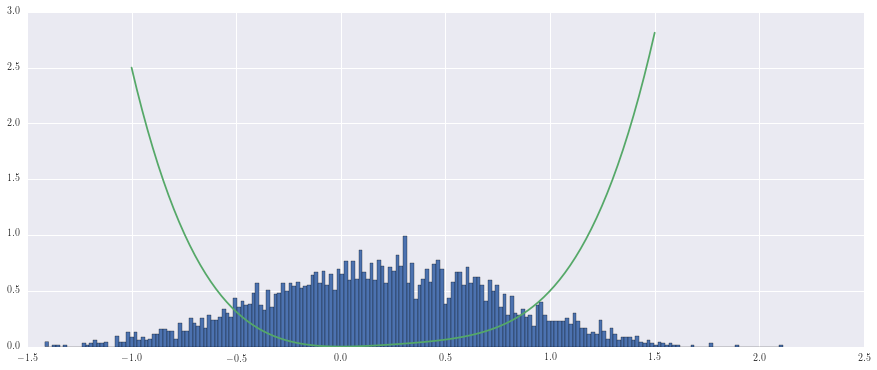

In [40]:
plt.hist(data,bins=200,normed=True)
xs=np.linspace(-1,1.5,100)
plt.plot(xs,V(xs,g_cubic,g_quartic))
